<a href="https://colab.research.google.com/github/ZiggerZZ/taxitime/blob/master/EDA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys
cwd = os.getcwd()

# Airport Data

In [0]:
# load complete_data from github which is the post-processed dataset

df = pd.read_csv('https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/complete_data.csv')

In [0]:
# when df loads from csv certain time columns are no longer datetime so need to recast them

df.actual_landing_time = pd.to_datetime(df.actual_landing_time)
df.actual_inblock_time = pd.to_datetime(df.actual_inblock_time)
df.date = pd.to_datetime(df.date)

## Taxi Time Outliers

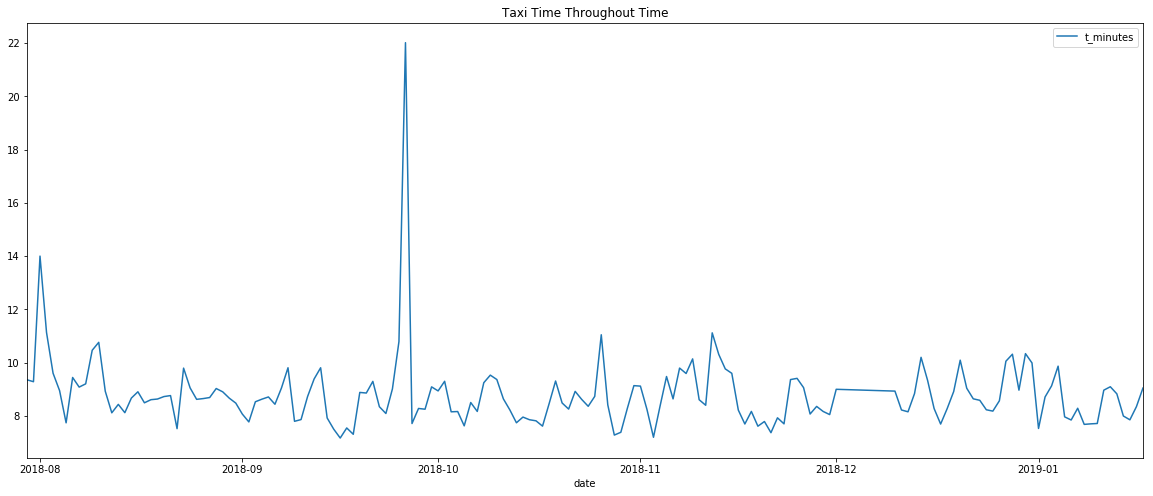

In [0]:
df["date"] = df.actual_landing_time.dt.date
df.groupby("date").mean().plot(y='t_minutes',figsize = (20, 8), title='Taxi Time Throughout Time')

## Categorical Variables

__Carriers:__

In [0]:
df['carrier'].unique()

array(['CAR1', 'CAR4', 'CAR3', 'CAR2'], dtype=object)

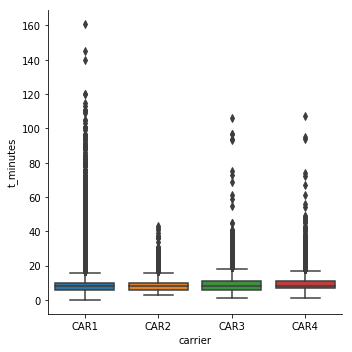

In [0]:
order = df["carrier"].unique()
order.sort()
sns.catplot(x="carrier", y = "t_minutes",kind="box", data = df, order = order) 

(0, 20)

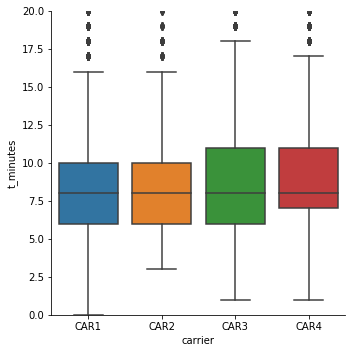

In [0]:
# same plot but with y limit

order = df["carrier"].unique()
order.sort()
sns.catplot(x="carrier", y = "t_minutes",kind="box", data = df, order = order) 
plt.ylim(0, 20)


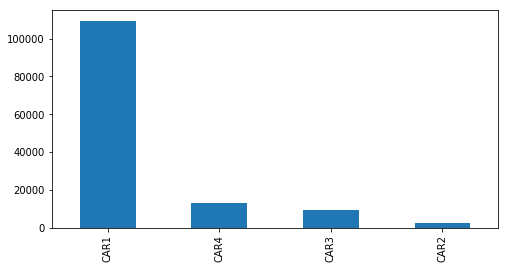

In [0]:
# get count by carrier
plt.figure(figsize=(8,4))
pd.value_counts(df['carrier']).plot.bar()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

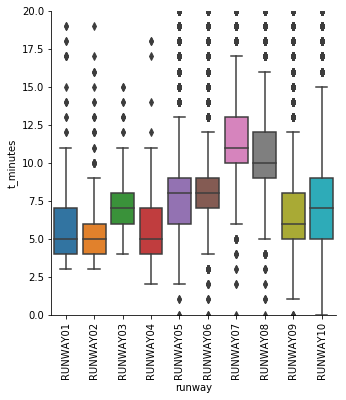

In [0]:
order = df["runway"].unique()
order = [x for x in order if str(x) != 'nan']
order.sort()
sns.catplot(x="runway", y = "t_minutes",kind="box", data = df, order = order) 
plt.ylim(0, 20)
plt.xticks(rotation=90)

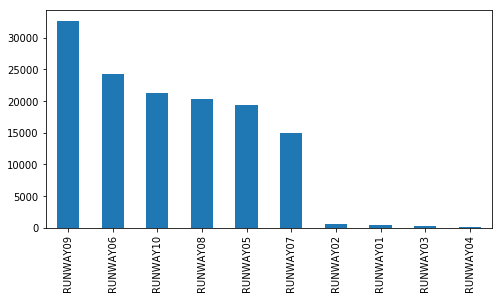

In [0]:
# get count by carrier
plt.figure(figsize=(8,4))
pd.value_counts(df['runway']).plot.bar()


In [0]:
carrier_runway_table = pd.crosstab(index=df["carrier"], 
                          columns=df["runway"])

carrier_runway_table

runway,RUNWAY01,RUNWAY02,RUNWAY03,RUNWAY04,RUNWAY05,RUNWAY06,RUNWAY07,RUNWAY08,RUNWAY09,RUNWAY10
carrier,,,,,,,,,,
CAR1,321,480,267,64,15823,20343,11837,15986,26924,17650
CAR2,4,1,0,0,406,591,213,355,742,205
CAR3,11,7,3,2,1412,1300,1293,1843,2132,1321
CAR4,27,20,9,3,1797,2077,1613,2195,3032,2191


__runways 01-04 almost not used__

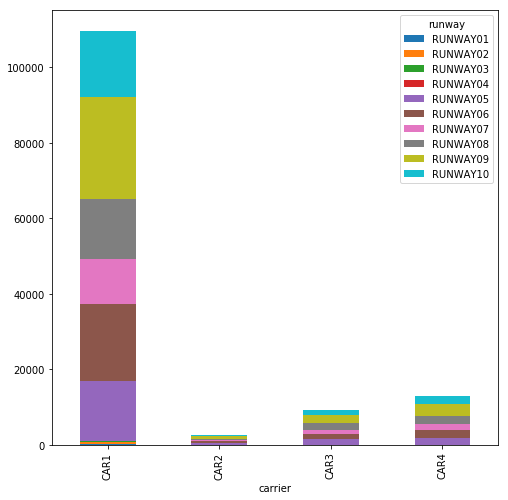

In [0]:
carrier_runway_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

# Weather Data

In [0]:
weather_link = 'https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/Taxi-time%20Prediction%20Data/2.%20Weather%20data/weather_data_prep.csv'
weather = pd.read_csv(weather_link)

rename_dict = {'WSF2': 'fastest_2_minute_wind_speed',
 'WSF5': 'fastest_5_second_wind_speed',
 'PRCP': 'precipitation',
 'SNWD': 'snow_depth',
 'WDF2': 'direction_of_fastest_2_minute_wind',
 'AWND': 'average_wind_speed',
 'WDF5': 'direction_of_fastest_5_second_wind',
 'PGTM': 'peak_gust_time',
 'TMAX': 'maximum_temperature',
 'TAVG': 'average_temperature',
 'TMIN': 'minimum_temperature',
 'WT03': 'thunder',
 'WT02': 'heavy_fog_or_heaving_freezing_fog',
 'WT01': 'fog,_ice_fog,_or_freezing_fog_(incl_heavy_fog)',
 'WT08': 'smoke_or_haze',
 'SNOW': 'snowfall'}

weather.rename(columns=rename_dict, inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dc7bf36d8>,
      dtype=object)

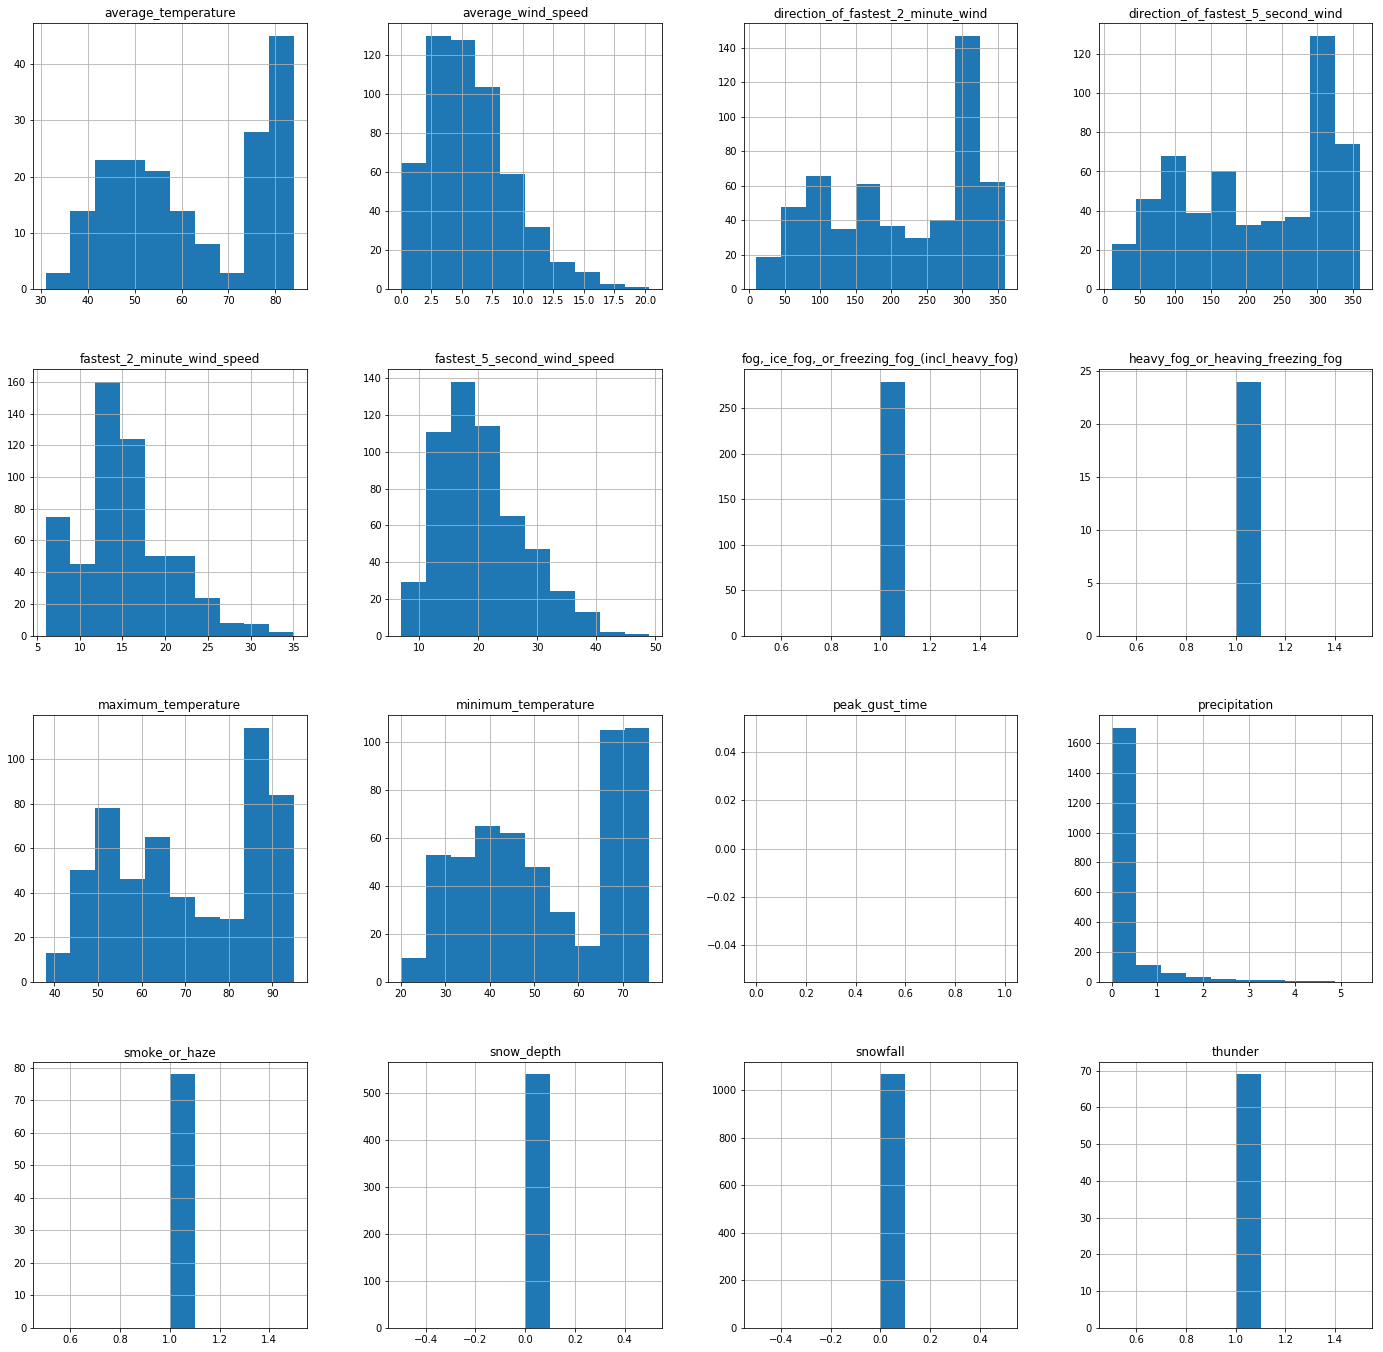

In [0]:
weather.hist(figsize=(24,24))

In [0]:
df.head()

,carrier,flight,acType,runway,stand,actual_landing_time,actual_inblock_time,t,t_minutes,scheduled_time_off,estimated_inblock_time,calculated_inblock_time,estimated_off_block_time,actual_off_block_time,actual_take_off_time
4,CAR1,2519,B737/9-WL,RUNWAY02,STAND04,2018-07-30 04:25:00,2018-07-30 04:29:00,00:04:00,4.0,2018-07-30 04:45:00,2018-07-30 04:33:00,2018-07-30 04:33:00,NaN,NaN,NaN
7,CAR1,1757,B757/2-WL,RUNWAY02,STAND07,2018-07-30 08:14:00,2018-07-30 08:18:00,00:04:00,4.0,2018-07-30 08:53:00,2018-07-30 08:19:00,2018-07-30 08:18:00,NaN,NaN,NaN
8,CAR1,1636,A321/2,RUNWAY01,STAND08,2018-07-30 08:26:00,2018-07-30 08:29:00,00:03:00,3.0,2018-07-30 08:49:00,2018-07-30 08:31:00,2018-07-30 08:32:00,NaN,NaN,NaN
9,CAR1,2048,B737/9-WL,RUNWAY02,STAND09,2018-07-30 08:42:00,2018-07-30 08:46:00,00:04:00,4.0,2018-07-30 08:56:00,2018-07-30 08:47:00,2018-07-30 08:45:00,NaN,NaN,NaN
11,CAR1,2510,A321/2,RUNWAY02,STAND11,2018-07-30 08:52:00,2018-07-30 08:57:00,00:05:00,5.0,2018-07-30 09:14:00,2018-07-30 08:57:00,2018-07-30 08:57:00,NaN,NaN,NaN


In [0]:
# weather data is not unique by day, so for now we will take the average of each column 
weather_data_grouped = weather.groupby('DATE', as_index=False).mean() 

weather_data_grouped['DATE'] = weather_data_grouped.DATE.apply(split_date_time,1) #change to timestamp
weather_data_grouped['DATE_join'] = weather_data_grouped['DATE'].astype(str) #create join col
df['actual_landing_day_join'] = df['actual_landing_time'].dt.date.astype(str) #create join col

# merge weather data and airport df
df = df[['actual_landing_day_join','actual_landing_time','t_minutes']].merge(weather_data_grouped, how='left', left_on='actual_landing_day_join', right_on='DATE_join')

# delete the join cols for both datasets
df.drop(['DATE', 'DATE_join'], axis = 1, inplace = True)
weather_data_grouped.drop(['DATE', 'DATE_join'], axis=1, inplace = True)

In [0]:
df.head()

,actual_landing_time,t_minutes,average_wind_speed,peak_gust_time,precipitation,snowfall,snow_depth,average_temperature,maximum_temperature,minimum_temperature,direction_of_fastest_2_minute_wind,direction_of_fastest_5_second_wind,fastest_2_minute_wind_speed,fastest_5_second_wind_speed,"fog,_ice_fog,_or_freezing_fog_(incl_heavy_fog)",heavy_fog_or_heaving_freezing_fog,thunder,smoke_or_haze
0,2018-07-30 04:25:00,4.0,4.173333,NaN,0.006667,0.0,0.0,79.0,87.0,70.333333,153.333333,153.333333,14.033333,17.733333,1.0,NaN,1.0,1.0
1,2018-07-30 08:14:00,4.0,4.173333,NaN,0.006667,0.0,0.0,79.0,87.0,70.333333,153.333333,153.333333,14.033333,17.733333,1.0,NaN,1.0,1.0
2,2018-07-30 08:26:00,3.0,4.173333,NaN,0.006667,0.0,0.0,79.0,87.0,70.333333,153.333333,153.333333,14.033333,17.733333,1.0,NaN,1.0,1.0
3,2018-07-30 08:42:00,4.0,4.173333,NaN,0.006667,0.0,0.0,79.0,87.0,70.333333,153.333333,153.333333,14.033333,17.733333,1.0,NaN,1.0,1.0
4,2018-07-30 08:52:00,5.0,4.173333,NaN,0.006667,0.0,0.0,79.0,87.0,70.333333,153.333333,153.333333,14.033333,17.733333,1.0,NaN,1.0,1.0


### Correlation among Variables

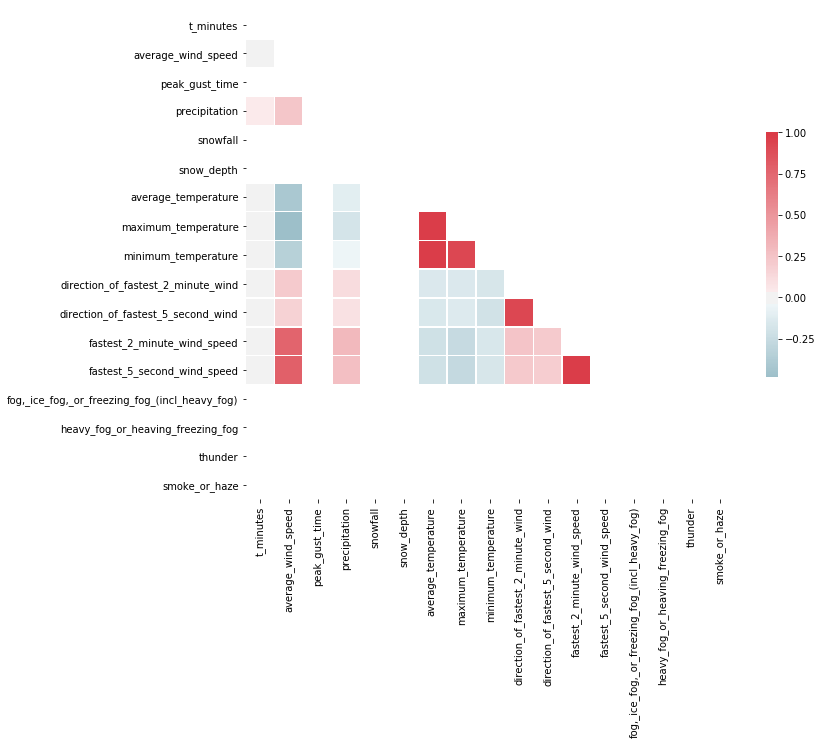

In [0]:
corr = merged.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Comments:

*   Maximum_temperature, Minimum_temperature and average_temperature highly correlated with eachother. We will only take average_temperature as it has the highest correlation to t_minutes.

*   fasted_2_minute_wind_speed and fasted_5_second_wind_speed are highly correlated. We keep 5 second because higher correlation with t_minutes



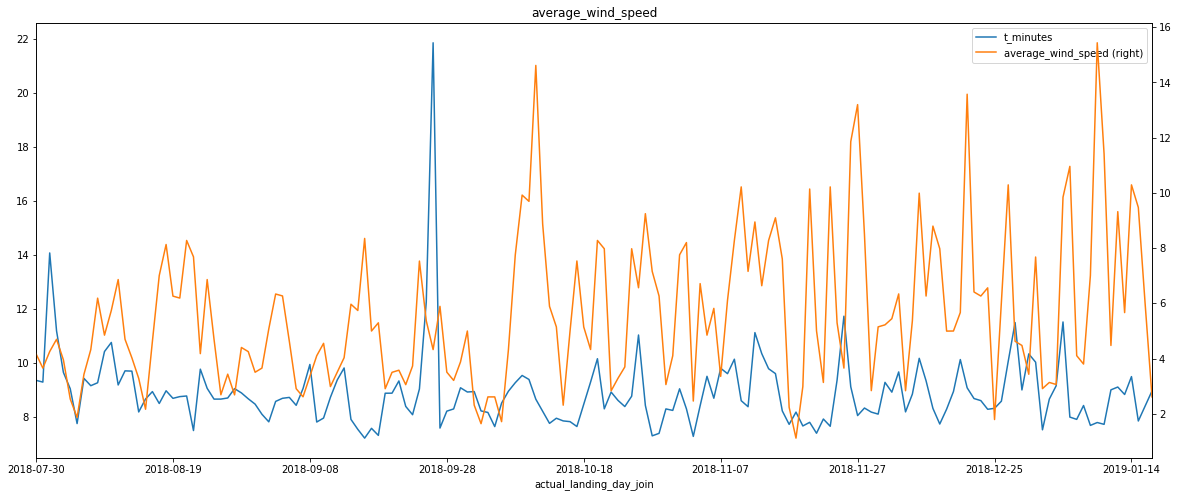

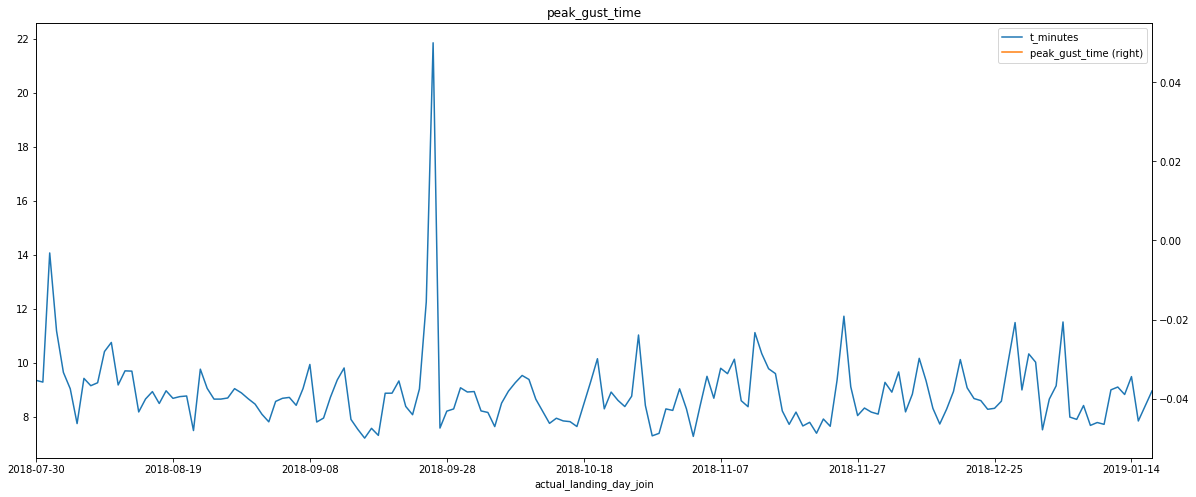

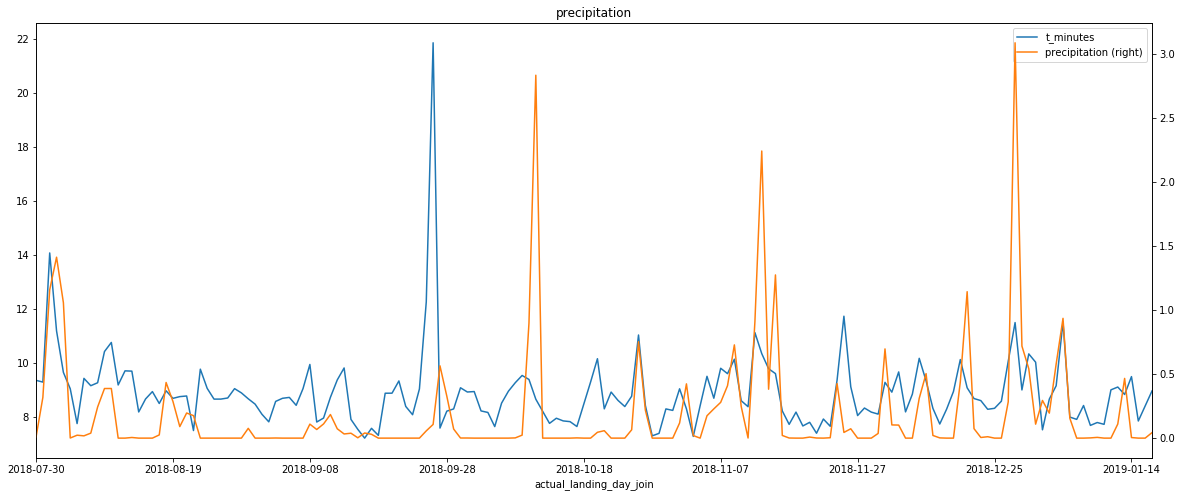

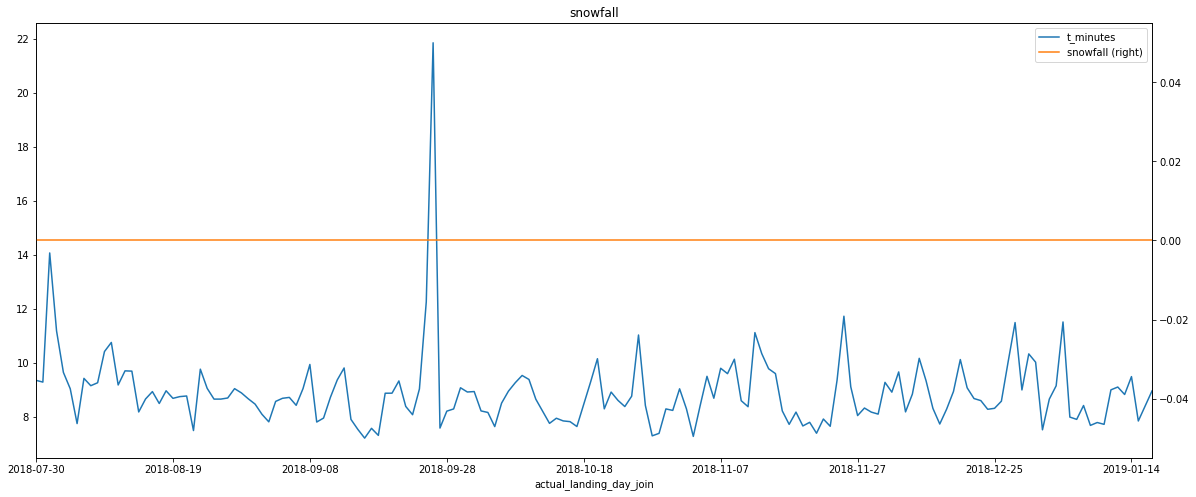

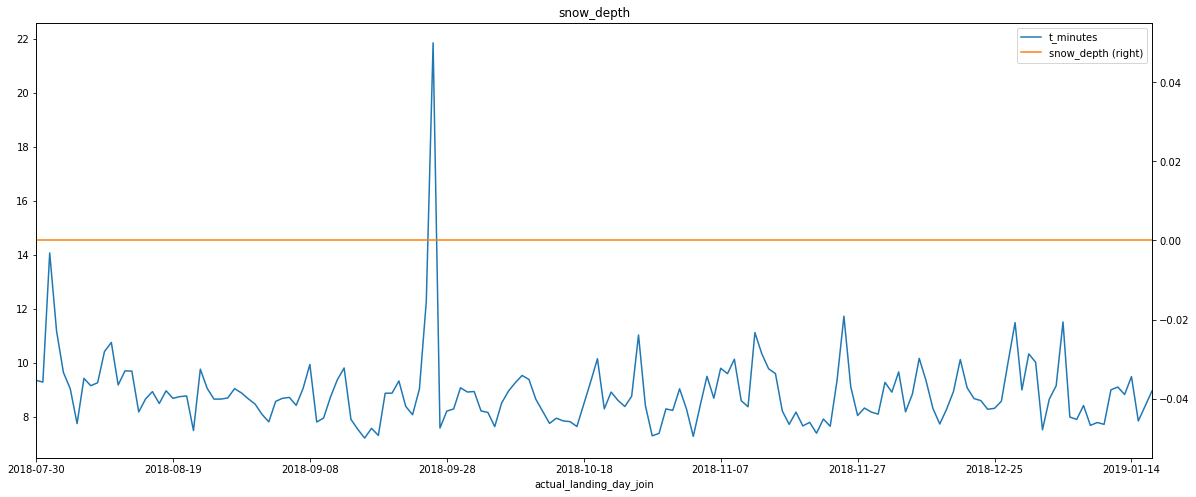

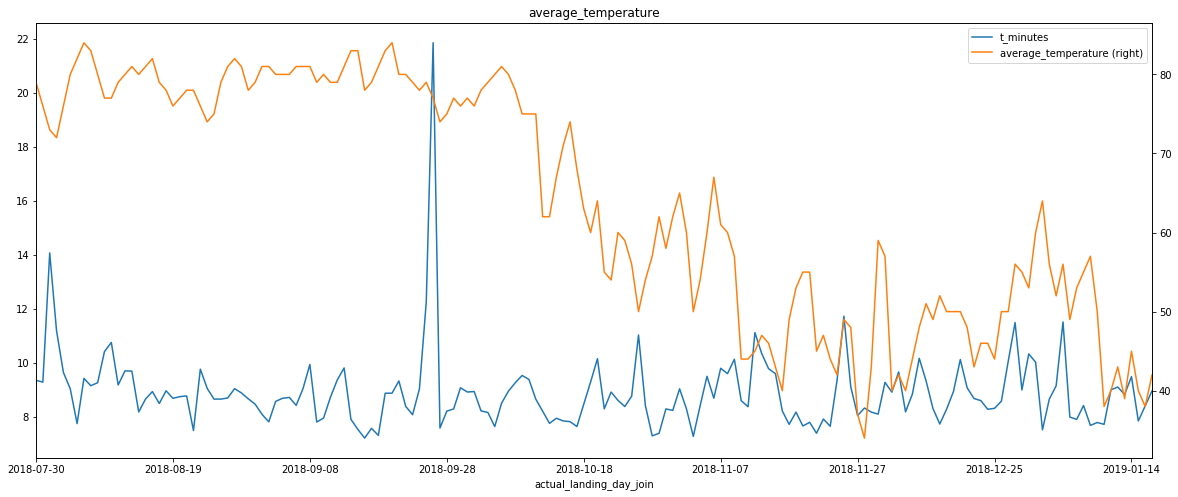

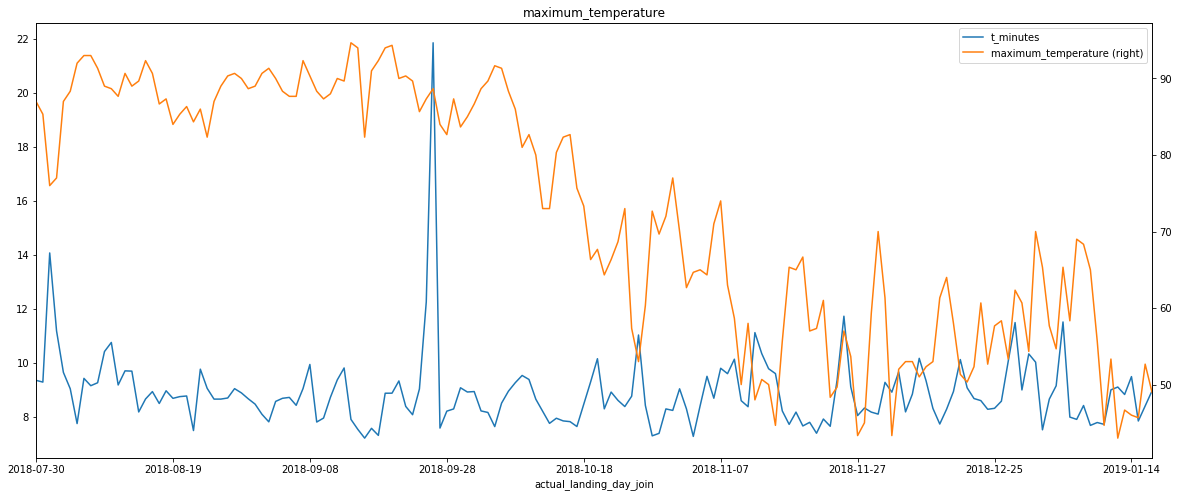

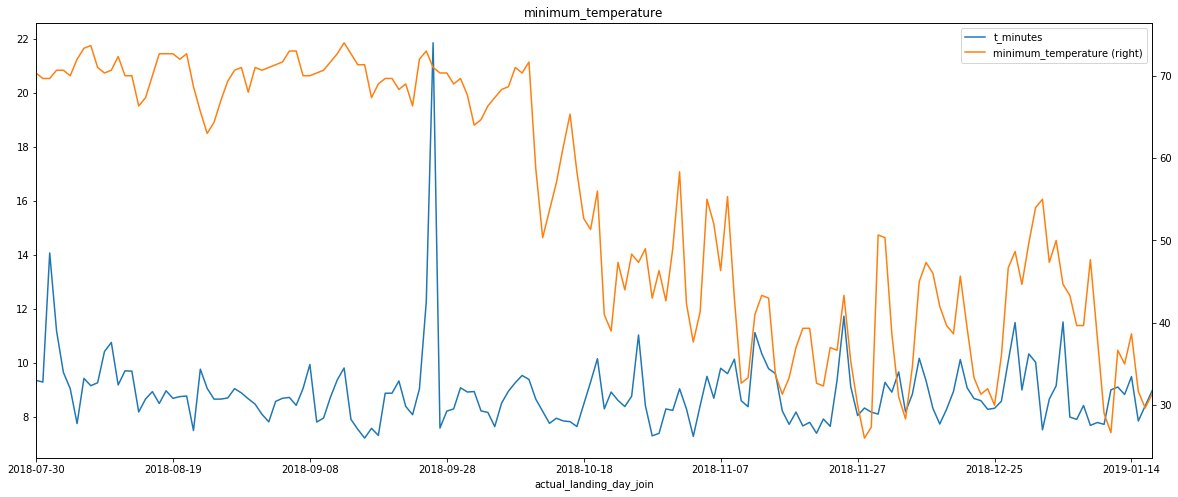

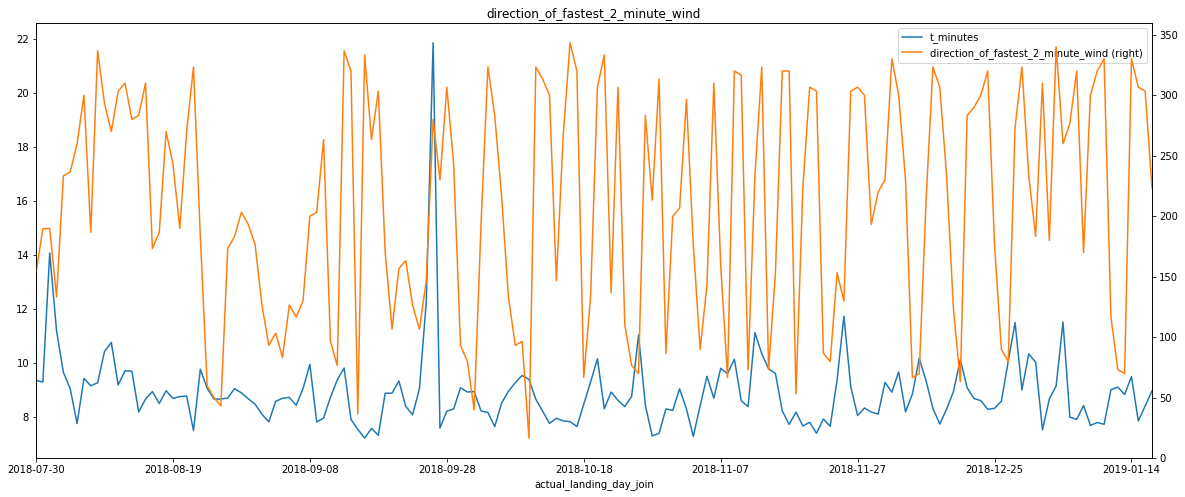

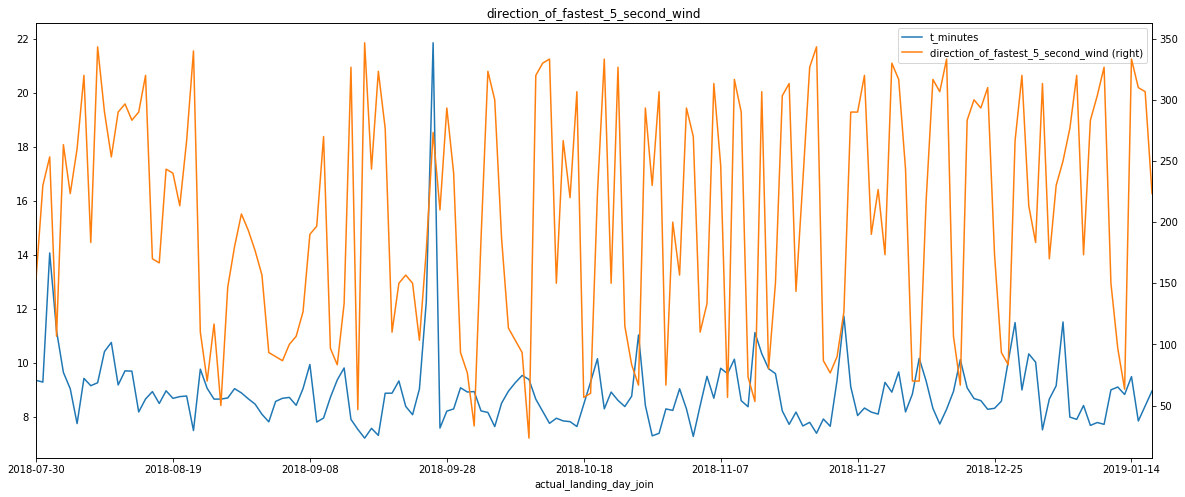

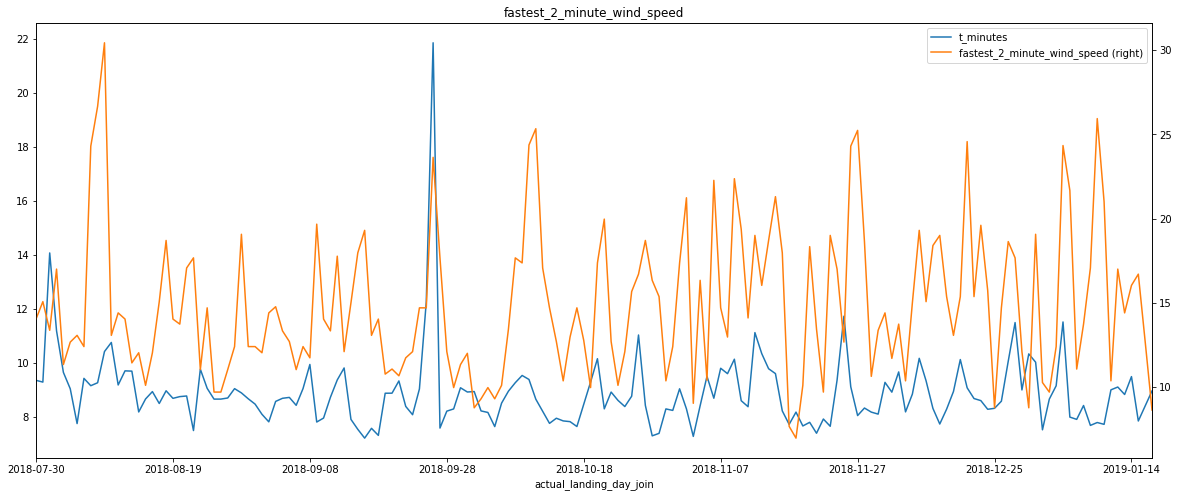

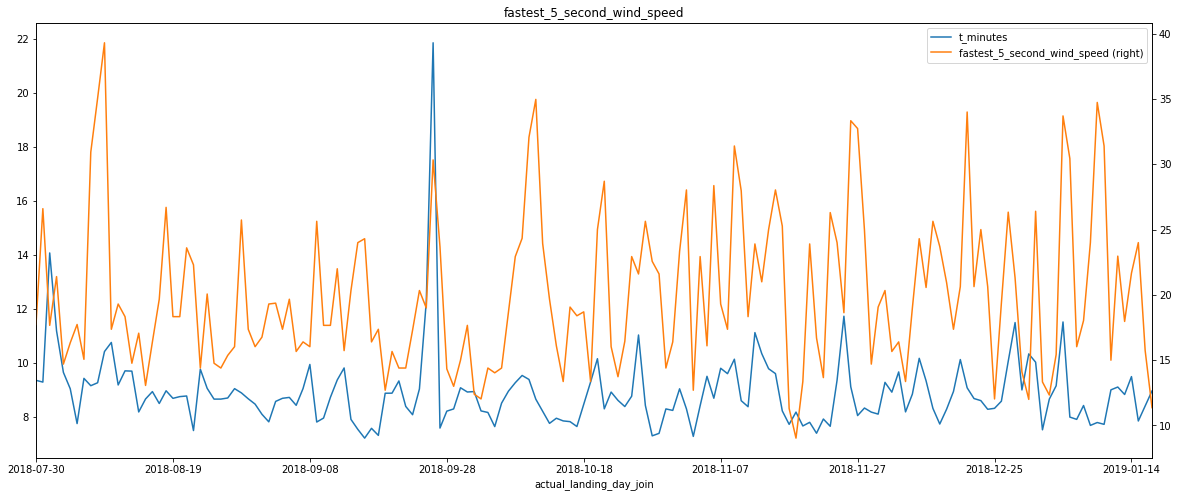

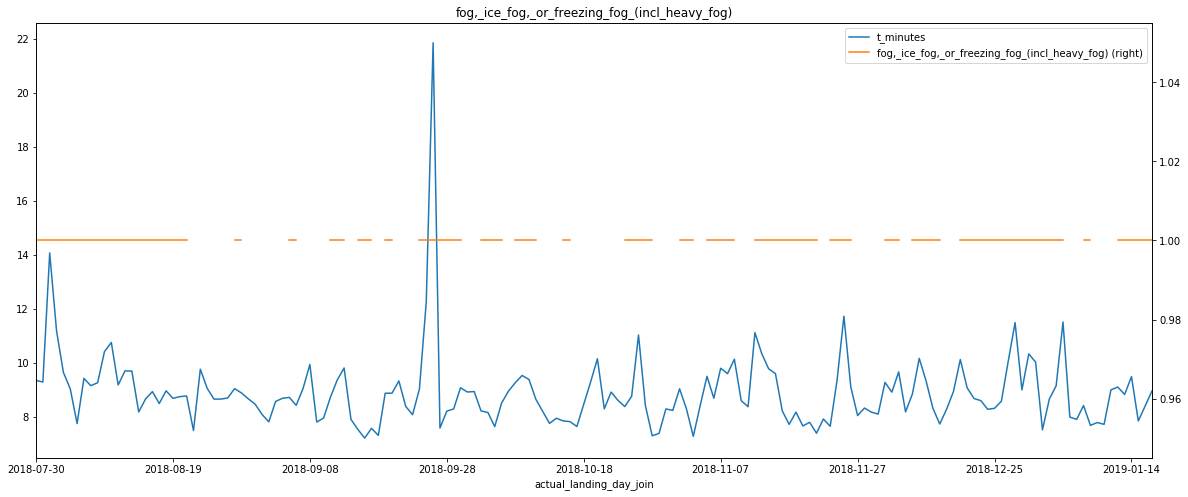

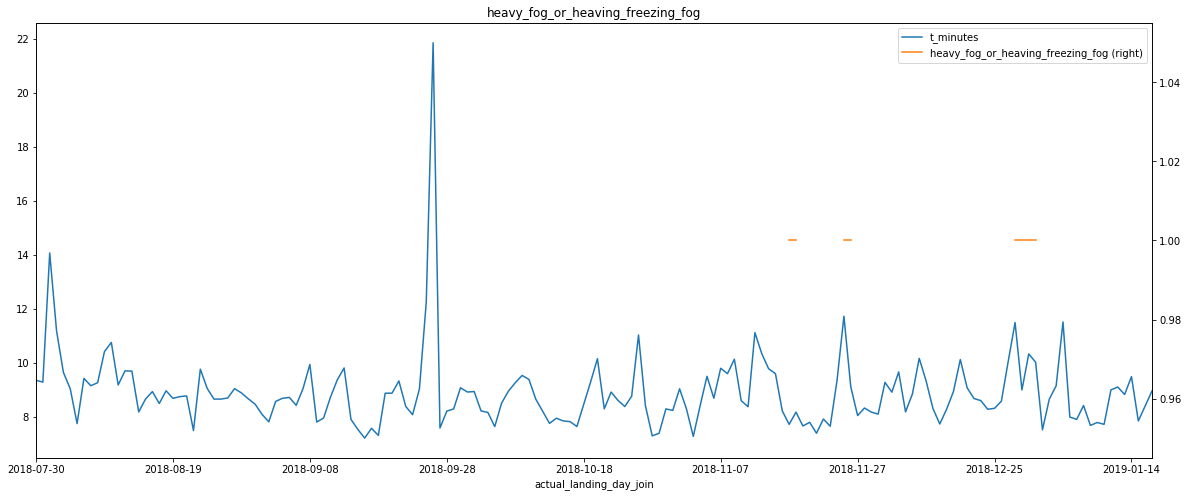

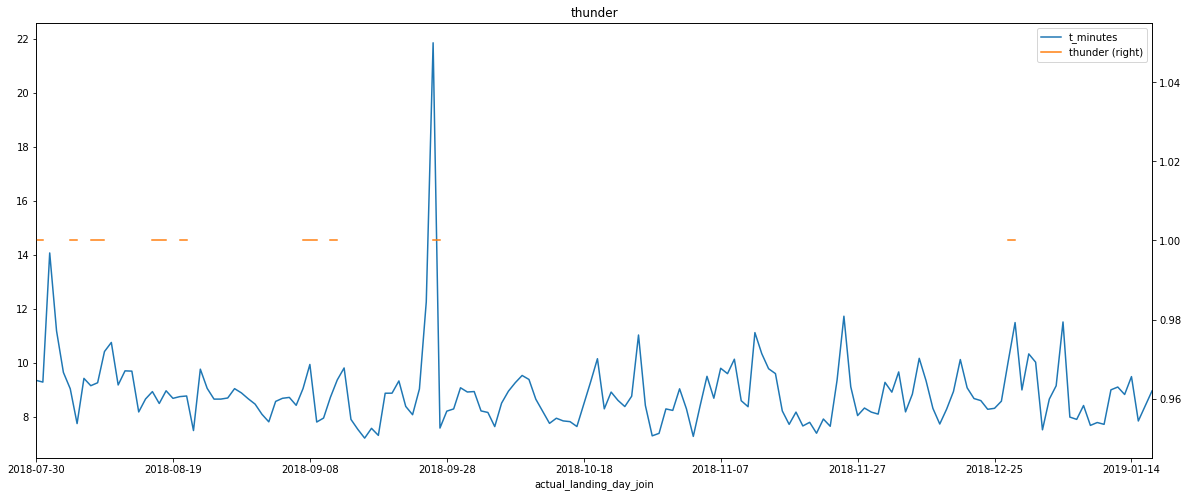

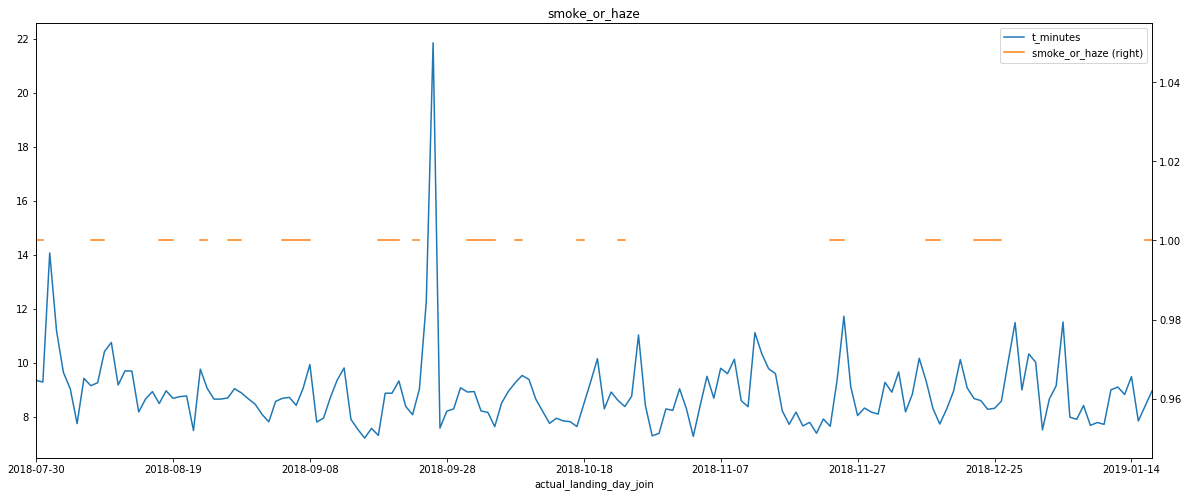

In [0]:
summary = df.groupby('actual_landing_day_join', as_index=False).agg('mean')
for e in summary.columns[2:]:
    ax_minutes = summary.plot('actual_landing_day_join','t_minutes')
    summary.plot('actual_landing_day_join',e,secondary_y=True, ax=ax_minutes, figsize=(20,8), title=e)


### Columns to delete:

*   snowfall (all 0 values)
*   snow_depth (all 0 values)
*   peak_gust_time (no values at all)

### Comments:

*   We can see that precipitation seems to be well correlated with t_minutes.
*   Very high average t_minutes around 2019-09-28 that seems to be linked with a thunder, or fog. 





### Weather Data - Boolean Fields

In [0]:
boolean_fields = ['fog,_ice_fog,_or_freezing_fog_(incl_heavy_fog)',
                  'heavy_fog_or_heaving_freezing_fog',
                  'thunder',
                  'smoke_or_haze']

# replace nulls with 0
df[boolean_fields] = df[boolean_fields].fillna(0)

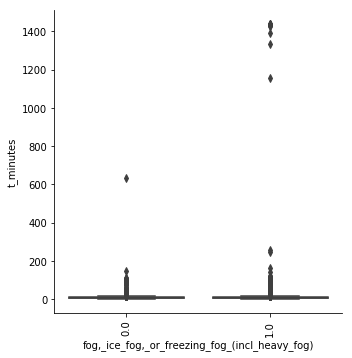

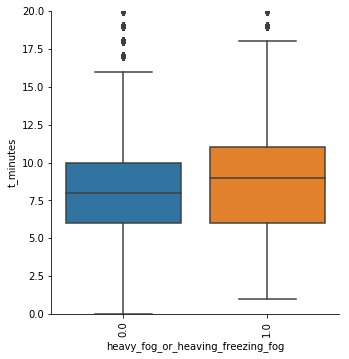

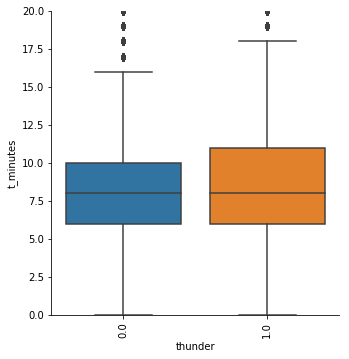

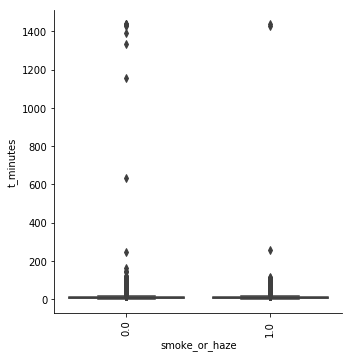

In [0]:
for e in boolean_fields:
    sns.catplot(x=e, y = "t_minutes" ,kind="box", data = df)
    if e in ['heavy_fog_or_heaving_freezing_fog',
                  'thunder']:
        plt.ylim(0, 20)
    plt.xticks(rotation=90)

Above, we compare the difference in t_minutes for each individual weather problem. For fog, there seems to be a difference in t_minutes for arrivals that have had fog or heavy fog.

In [0]:
# Combine Weather problems

df['abnormal_conditions'] = df[boolean_fields].apply(lambda x: sum(x),1)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

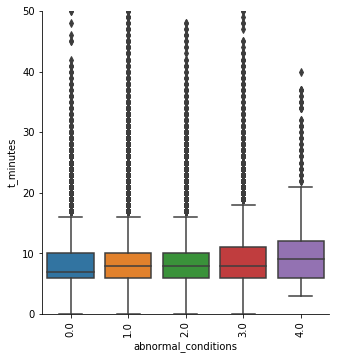

In [0]:
sns.catplot(x='abnormal_conditions', y = "t_minutes" ,kind="box", data = df)
plt.ylim(0, 50)
plt.xticks(rotation=90)

When there exist abnormal weather conditions, there are higher t_minutes 